# Классификация изображений с эмоциями людей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.12.0
GPU Device Not Found. Running on CPU


# <b>ВВЕДЕНИЕ</b>

Модели для данной работы были разработаны инструментами библиотек PyTorch, TensorFlow, Scikit-learn. После ряда экспериментов были отобраны по две модели на каждый фреймворк.

Используемый датасет собран нами вручную под конкретную задачу из имеющейся в нашем распоряжении базы данных изображений (около 140 тысяч изображений).

Конечный документ обучен с ипользованием GPU, предоставляемых платформой "Kaggle".

# <b>1. ПОДГОТОВИТЕЛЬНЫЙ ЭТАП</b>

## 1.1. Подготовка файлов для работы с локального диска

### Загрузка данных на локальный диск

Данную ячейку по очистке рабочей директории  запускать **ТОЛЬКО** в ноутбуках Kaggle перед началом обучения на GPU.

In [2]:
# # DO NOT RUN ON YOUR LOCAL MACHINE!!!

# import os
# dir_to_delete = '/kaggle/working/'
# with os.scandir(dir_to_delete) as entries:
#     for entry in entries:
#         file_to_delete = f"{dir_to_delete}{entry.name}"
#         if os.path.isfile(file_to_delete):
#             print(file_to_delete)
#             os.remove(file_to_delete)

# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [3]:
# # активировать при обучении в Kaggle
# !pip install gdown

In [4]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output=fname+'.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: /content/emotions.zip
100%|██████████| 14.8M/14.8M [00:00<00:00, 50.0MB/s]


Распаковка в текущую директорию.

In [5]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Теперь загруженный архив можно удалить.

In [6]:
import os

os.remove(fname + '.zip')

Переименуем папку с изображениями в `emotions`. Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [7]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [8]:
zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [9]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

### Настройка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [10]:
from pathlib import Path

# Базовая директория
classes = sorted(os.listdir(base_dir))

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [11]:
# class_names = [x.lower() for x in classes]
class_names = sorted(['anger', 'disgust', 'fear', 'joyfulness', 'neutral'])

done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(sorted(class_names)):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = sorted(os.listdir(base_dir))

In [12]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

### Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [13]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [14]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] 5a971597aae6052a008b45a7.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] Universal_Expression_Disgust.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] gettyimages-520925691.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [15]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


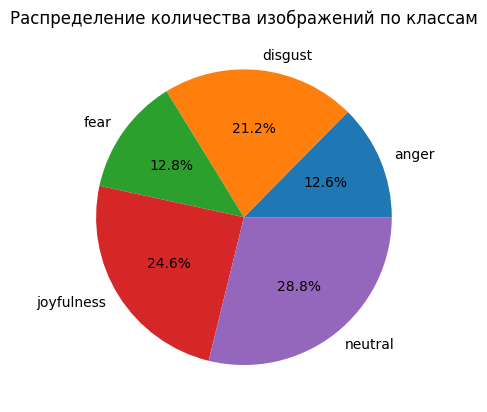

In [16]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать метрики, основанные на `precision` и `recall`, а также матрицу ошибок.

In [17]:
print(len(class_names))

5


Посмотрим на названия отдельных файлов.

In [18]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['4025.jpg', '136535.jpg', '19609.jpg']
disgust ['88395.jpg', '147952.jpg', '188755.jpg']
fear ['214143.jpg', '221981.jpg', '17279.jpg']
joyfulness ['7608.jpg', '4270.jpg', '14885.jpg']
neutral ['2886.jpg', '150343.jpg', '24634.jpg']


### Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

In [20]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

### Создание DataFrame для "случайного леса"

Для "случайного леса" изображения необходимо перевести в векторы, объединить эти векторы в одну DataFrame, добавив последним столбцом номера классов (от 0 до 4, ординальная кодировка). Следующий код аккуратно проделает все операции, на выходе мы получаем желаемую DataFrame, после чего ее можно будет разделить средствами библиотеки sklearn на обучающую и валидационную части.

In [21]:
# import pandas as pd
# from PIL import Image

# # создадим пустые списки для векторов по классам
# anger_features = []
# disgust_features = []
# fear_features = []
# joyfulness_features = []
# neutral_features = []
# features_lst= sorted([anger_features, disgust_features,
#                       fear_features, joyfulness_features,
#                       neutral_features])

# # переведем изображения в вектора, добавим таргет
# # и сохраним в списках
# final_df = pd.DataFrame()  # пустой датафрейм
# for name, lst in zip(class_names, features_lst):
#     fpath = base_dir / name
#     lst_idx = features_lst.index(lst)
#     for img in os.listdir(fpath):

#         img = Image.open(fpath/img)
#         img = np.array(img)

#         if img.shape == (224, 224, 3):

#             a = np.reshape(img, (224*224*3))
#             b = np.ones(1, dtype='uint8')*lst_idx
#             c = np.append(a, b)
#             lst.append(c)

#     # добавим все данные в общую таблицу
#     final_df = pd.concat([final_df, pd.DataFrame(lst)], axis=0)

# final_df.index = range(final_df.shape[0])

In [22]:
# final_df.info()

In [23]:
# final_df.shape

### Split изображений для нейросетей

Так как для оценки работы нейросетей мы создаем отдельный датасет с тестовыми изображениями и в одном из используемых фреймворков (tensorflow) готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами. После этого создать датасеты для torch, tf и sklearn будет несложно.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [24]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):

    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num

    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [25]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=sorted(classes)[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении примерно 8 : 1.2 : 0.8. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [26]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

test ['anger', 'neutral', 'disgust', 'fear', 'joyfulness']
validation ['anger', 'neutral', 'disgust', 'fear', 'joyfulness']
train ['anger', 'neutral', 'disgust', 'fear', 'joyfulness']


# 1.2. Подготовка функций и переменных для обучения | <b>PyTorch</b>

In [27]:
!pip install --pre torcheval-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.4 MB/s eta 0:00:00


In [28]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.4 MB/s eta 0:00:00


In [29]:
import torch
from torcheval.metrics.functional import multiclass_f1_score

In [30]:
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00


In [31]:
import os
import time
import wandb
import shutil 
from pathlib import Path

import numpy as np 
import random

from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
import copy
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torch.optim import lr_scheduler
import torch.backends.cudnn

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
import albumentations as A
import albumentations.pytorch as AP
from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, RandomCrop,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomScale, RandomGridShuffle,
    RandomContrast, RandomGamma, RandomBrightness, CenterCrop, VerticalFlip, ColorJitter,
    ChannelShuffle, InvertImg, RGBShift, ElasticTransform, Equalize, RandomResizedCrop, ChannelDropout
)
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function, division


from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import datetime as dt
import pandas as pd

import timm

[INFO] Couldn't find torchinfo... installing it.


In [32]:
# ====================================================
# CFG - класс с параметрами нашего эксперимента
# ====================================================

class CFG:

    num_workers=2
    model_name = 'ResNet emo'
    size=(224,224)
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42
    

    api = "c46873158d9b17d359eb43bbe31308d56f8ce3d4"# вписать свой API Wandb  
    project = "ready_go"# вписать название эксперимента, который предварительно надо создать в Wandb
    entity = "gret-ell"# ввести свой логин
    wandb = False # флаг использования Wandb

In [33]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [34]:
def seed_everything(seed):
    random.seed(CFG.seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(CFG.seed) # фиксируем заполнения хешей. PYTHONHASHSEED переменная среды с фиксированным значением
    np.random.seed(CFG.seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(CFG.seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(CFG.seed) # фиксируем генератор случайных чисел для GPU

In [35]:
# поканальные значения среднего и стандартного отклонения для ImageNet, на котором предобучены модели, которые используются в этой работе.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [37]:
dataset = torchvision.datasets.ImageFolder("/content/data/emotions")

In [38]:
dataset

Dataset ImageFolder
    Number of datapoints: 1380
    Root location: /content/data/emotions

In [39]:
# Data augmentation and normalization for training
# Только нормализация применима к validation
# ПРИМЕЧАНИЕ: использовать не более 2-х процессоров, иначе выходит предупреждение, что слишком высокое количество.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
}

data_dir = '/content/data/emotions'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=CFG.batch_size,
                                             shuffle=True, num_workers=CFG.num_workers)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.5)  # установим паузу, чтобы графики успевали обновлятся


# Берем батч из training data
inputs, classes = next(iter(dataloaders['train']))

# Вынимаем из батча изображение
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Функция для тренировки моделей. Общая

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=CFG.epochs):
    since = time.time()
    loss_hist = {'train':[], 'validation':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_f1 = 0.0

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # В каждой эпохе есть training и validation фаза
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Переводим модель в training mode
            else:
                model.eval()   # Переводим модель в evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Итерируемся.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                # forward
                # отслеживание истории только в train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize только если training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # подсчет статистики
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = multiclass_f1_score(outputs, labels, num_classes=len(class_names))

            print(f'{phase}   |   Loss: {epoch_loss:.4f}  |  Acc: {epoch_acc:.4f}   |   F1: {epoch_f1:.4f}')
            
            # Передача данных в сервис wandb
            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'validation':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc,
                   'test_F1': epoch_f1})
            # deep copy модели
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    

    # загрузка best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_hist

Визуализация результата предсказания модели

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Первая модель. Предобученная модель Resnet18. По рекомендациям разработчика, теперь надо указывать не pretrained=True, а предобученные веса модели.

In [ ]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True. Рекомендации разработчика использовать веса, вместо pretrained=True

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer_ft)

# Уменьшим LR на  0.1 каждые 7 эпох
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_ft, 
        input_size=(8, 3, 224, 224), # входной батч
        col_names=["input_size", "output_size", "num_params"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNet                                   [8, 3, 224, 224]     [8, 5]               --
├─Conv2d: 1-1                            [8, 3, 224, 224]     [8, 64, 112, 112]    9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]    [8, 64, 112, 112]    128
├─ReLU: 1-3                              [8, 64, 112, 112]    [8, 64, 112, 112]    --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]    [8, 64, 56, 56]      --
├─Sequential: 1-5                        [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]      [8, 64, 56, 56]      36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]      [8, 64, 56, 56]      128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-4                 

In [ ]:
model_ft, loss_hist = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:08<00:00, 16.57it/s]


train   |   Loss: 1.3966  |  Acc: 0.4250   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 27.72it/s]


validation   |   Loss: 1.0221  |  Acc: 0.6038   |   F1: 0.7143

Epoch 1/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.63it/s]


train   |   Loss: 1.1119  |  Acc: 0.5750   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.70it/s]


validation   |   Loss: 0.8218  |  Acc: 0.6792   |   F1: 0.8571

Epoch 2/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.37it/s]


train   |   Loss: 1.0156  |  Acc: 0.6157   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.20it/s]


validation   |   Loss: 0.7284  |  Acc: 0.7233   |   F1: 0.7143

Epoch 3/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.68it/s]


train   |   Loss: 0.8073  |  Acc: 0.6963   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.74it/s]


validation   |   Loss: 0.7984  |  Acc: 0.7358   |   F1: 0.5714

Epoch 4/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.34it/s]


train   |   Loss: 0.8251  |  Acc: 0.6981   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.50it/s]


validation   |   Loss: 0.5984  |  Acc: 0.7987   |   F1: 0.7143

Epoch 5/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.54it/s]


train   |   Loss: 0.7203  |  Acc: 0.7296   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.64it/s]


validation   |   Loss: 0.4210  |  Acc: 0.8428   |   F1: 0.8571

Epoch 6/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.49it/s]


train   |   Loss: 0.7159  |  Acc: 0.7407   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 13.34it/s]


validation   |   Loss: 0.5945  |  Acc: 0.7987   |   F1: 0.7143

Epoch 7/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.72it/s]


train   |   Loss: 0.5740  |  Acc: 0.7870   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 19.14it/s]


validation   |   Loss: 0.4931  |  Acc: 0.8428   |   F1: 0.7143

Epoch 8/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.23it/s]


train   |   Loss: 0.5095  |  Acc: 0.8167   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 26.78it/s]


validation   |   Loss: 0.4913  |  Acc: 0.8491   |   F1: 1.0000

Epoch 9/29
----------


100%|██████████| 135/135 [00:08<00:00, 15.49it/s]


train   |   Loss: 0.4854  |  Acc: 0.8241   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 17.91it/s]


validation   |   Loss: 0.4934  |  Acc: 0.8491   |   F1: 0.8571

Epoch 10/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.00it/s]


train   |   Loss: 0.5144  |  Acc: 0.8046   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.30it/s]


validation   |   Loss: 0.4818  |  Acc: 0.8616   |   F1: 0.8571

Epoch 11/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.35it/s]


train   |   Loss: 0.4981  |  Acc: 0.8083   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 17.78it/s]


validation   |   Loss: 0.4929  |  Acc: 0.8553   |   F1: 1.0000

Epoch 12/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.21it/s]


train   |   Loss: 0.5029  |  Acc: 0.8120   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.49it/s]


validation   |   Loss: 0.4944  |  Acc: 0.8428   |   F1: 0.8571

Epoch 13/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.39it/s]


train   |   Loss: 0.4940  |  Acc: 0.8287   |   F1: 0.5000


100%|██████████| 20/20 [00:01<00:00, 17.86it/s]


validation   |   Loss: 0.4857  |  Acc: 0.8428   |   F1: 0.8571

Epoch 14/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.30it/s]


train   |   Loss: 0.4451  |  Acc: 0.8407   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


validation   |   Loss: 0.4992  |  Acc: 0.8428   |   F1: 0.8571

Epoch 15/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.93it/s]


train   |   Loss: 0.4601  |  Acc: 0.8343   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 17.73it/s]


validation   |   Loss: 0.5006  |  Acc: 0.8616   |   F1: 0.8571

Epoch 16/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.25it/s]


train   |   Loss: 0.4379  |  Acc: 0.8333   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 27.44it/s]


validation   |   Loss: 0.4856  |  Acc: 0.8428   |   F1: 0.5714

Epoch 17/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.22it/s]


train   |   Loss: 0.4685  |  Acc: 0.8296   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 17.45it/s]


validation   |   Loss: 0.4849  |  Acc: 0.8302   |   F1: 0.8571

Epoch 18/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.58it/s]


train   |   Loss: 0.4534  |  Acc: 0.8231   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 26.46it/s]


validation   |   Loss: 0.4614  |  Acc: 0.8679   |   F1: 0.7143

Epoch 19/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.31it/s]


train   |   Loss: 0.4559  |  Acc: 0.8361   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


validation   |   Loss: 0.4979  |  Acc: 0.8302   |   F1: 0.7143

Epoch 20/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.59it/s]


train   |   Loss: 0.4514  |  Acc: 0.8426   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.58it/s]


validation   |   Loss: 0.4942  |  Acc: 0.8553   |   F1: 0.8571

Epoch 21/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.28it/s]


train   |   Loss: 0.4147  |  Acc: 0.8574   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 17.57it/s]


validation   |   Loss: 0.4741  |  Acc: 0.8553   |   F1: 1.0000

Epoch 22/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.97it/s]


train   |   Loss: 0.4376  |  Acc: 0.8454   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 27.34it/s]


validation   |   Loss: 0.5187  |  Acc: 0.8428   |   F1: 0.7143

Epoch 23/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.57it/s]


train   |   Loss: 0.4312  |  Acc: 0.8380   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 16.57it/s]


validation   |   Loss: 0.4823  |  Acc: 0.8491   |   F1: 1.0000

Epoch 24/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.40it/s]


train   |   Loss: 0.4207  |  Acc: 0.8472   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.56it/s]


validation   |   Loss: 0.4753  |  Acc: 0.8491   |   F1: 1.0000

Epoch 25/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.79it/s]


train   |   Loss: 0.4290  |  Acc: 0.8565   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 16.54it/s]


validation   |   Loss: 0.4672  |  Acc: 0.8491   |   F1: 0.8571

Epoch 26/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.87it/s]


train   |   Loss: 0.4634  |  Acc: 0.8296   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.39it/s]


validation   |   Loss: 0.4798  |  Acc: 0.8365   |   F1: 0.7143

Epoch 27/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.38it/s]


train   |   Loss: 0.4543  |  Acc: 0.8417   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 16.84it/s]


validation   |   Loss: 0.4824  |  Acc: 0.8491   |   F1: 0.7143

Epoch 28/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.32it/s]


train   |   Loss: 0.5058  |  Acc: 0.8093   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.48it/s]


validation   |   Loss: 0.4711  |  Acc: 0.8365   |   F1: 0.7143

Epoch 29/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.83it/s]


train   |   Loss: 0.4786  |  Acc: 0.8250   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 16.71it/s]

validation   |   Loss: 0.4570  |  Acc: 0.8491   |   F1: 0.7143

Training complete in 3m 37s
Best val Acc: 0.867925


In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

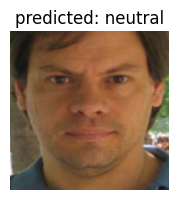

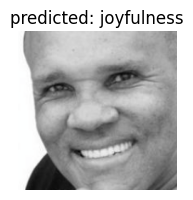

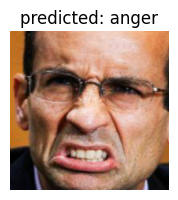

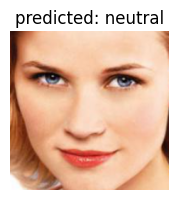

In [ ]:
visualize_model(model_ft)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

F1-Score macro:  0.8313792055897318
F1-Score micro:  0.8679245283018869
F1-Score weighted:  0.8646765092643941
[60.         91.17647059 70.         97.43589744 93.47826087]


Модель ResNet18 с заморозкой слоев.

In [ ]:
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False # Заморозим слои и проверим качество предсказаний

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer_conv)

In [ ]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_conv, 
        input_size=(8, 3, 224, 224), # входной батч
        col_names=["input_size", "output_size", "num_params"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNet                                   [8, 3, 224, 224]     [8, 5]               --
├─Conv2d: 1-1                            [8, 3, 224, 224]     [8, 64, 112, 112]    (9,408)
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]    [8, 64, 112, 112]    (128)
├─ReLU: 1-3                              [8, 64, 112, 112]    [8, 64, 112, 112]    --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]    [8, 64, 56, 56]      --
├─Sequential: 1-5                        [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]      [8, 64, 56, 56]      (36,864)
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]      [8, 64, 56, 56]      (128)
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-4         

In [ ]:
model_conv, loss_hist = train_model(model_conv, criterion, optimizer_conv,
                         scheduler, num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.14it/s]


train   |   Loss: 1.5347  |  Acc: 0.3657   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.96it/s]


validation   |   Loss: 1.4319  |  Acc: 0.3962   |   F1: 0.4286

Epoch 1/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.21it/s]


train   |   Loss: 1.3421  |  Acc: 0.4639   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.75it/s]


validation   |   Loss: 1.3150  |  Acc: 0.4780   |   F1: 0.7143

Epoch 2/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.05it/s]


train   |   Loss: 1.3306  |  Acc: 0.4806   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


validation   |   Loss: 1.3071  |  Acc: 0.4654   |   F1: 0.4286

Epoch 3/29
----------


100%|██████████| 135/135 [00:03<00:00, 35.02it/s]


train   |   Loss: 1.2384  |  Acc: 0.5259   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.02it/s]


validation   |   Loss: 1.3298  |  Acc: 0.4465   |   F1: 0.5714

Epoch 4/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.54it/s]


train   |   Loss: 1.2499  |  Acc: 0.4935   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 17.91it/s]


validation   |   Loss: 1.3828  |  Acc: 0.4717   |   F1: 0.4286

Epoch 5/29
----------


100%|██████████| 135/135 [00:05<00:00, 26.01it/s]


train   |   Loss: 1.1971  |  Acc: 0.5398   |   F1: 0.3750


100%|██████████| 20/20 [00:00<00:00, 26.54it/s]


validation   |   Loss: 1.2577  |  Acc: 0.4969   |   F1: 0.4286

Epoch 6/29
----------


100%|██████████| 135/135 [00:03<00:00, 35.02it/s]


train   |   Loss: 1.1855  |  Acc: 0.5315   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.35it/s]


validation   |   Loss: 1.2082  |  Acc: 0.5094   |   F1: 0.4286

Epoch 7/29
----------


100%|██████████| 135/135 [00:04<00:00, 28.10it/s]


train   |   Loss: 1.0975  |  Acc: 0.5750   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 15.94it/s]


validation   |   Loss: 1.1462  |  Acc: 0.5660   |   F1: 0.5714

Epoch 8/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.19it/s]


train   |   Loss: 1.0618  |  Acc: 0.5750   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.68it/s]


validation   |   Loss: 1.1585  |  Acc: 0.5220   |   F1: 0.2857

Epoch 9/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.27it/s]


train   |   Loss: 1.0484  |  Acc: 0.5991   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.75it/s]


validation   |   Loss: 1.1541  |  Acc: 0.5472   |   F1: 0.4286

Epoch 10/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.07it/s]


train   |   Loss: 1.0766  |  Acc: 0.5787   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 15.46it/s]


validation   |   Loss: 1.1584  |  Acc: 0.5346   |   F1: 0.2857

Epoch 11/29
----------


100%|██████████| 135/135 [00:09<00:00, 14.26it/s]


train   |   Loss: 1.0481  |  Acc: 0.5787   |   F1: 0.3750


100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


validation   |   Loss: 1.1675  |  Acc: 0.5346   |   F1: 0.4286

Epoch 12/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.69it/s]


train   |   Loss: 1.1128  |  Acc: 0.5769   |   F1: 0.2500


100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


validation   |   Loss: 1.1599  |  Acc: 0.5283   |   F1: 0.5714

Epoch 13/29
----------


100%|██████████| 135/135 [00:07<00:00, 17.38it/s]


train   |   Loss: 1.1183  |  Acc: 0.5574   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 13.19it/s]


validation   |   Loss: 1.1369  |  Acc: 0.5597   |   F1: 0.5714

Epoch 14/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.38it/s]


train   |   Loss: 1.0755  |  Acc: 0.5750   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 16.81it/s]


validation   |   Loss: 1.1709  |  Acc: 0.5472   |   F1: 0.7143

Epoch 15/29
----------


100%|██████████| 135/135 [00:07<00:00, 19.21it/s]


train   |   Loss: 1.0518  |  Acc: 0.6009   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


validation   |   Loss: 1.1609  |  Acc: 0.5597   |   F1: 0.8571

Epoch 16/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.57it/s]


train   |   Loss: 1.0400  |  Acc: 0.6009   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


validation   |   Loss: 1.1527  |  Acc: 0.5535   |   F1: 0.5714

Epoch 17/29
----------


100%|██████████| 135/135 [00:05<00:00, 26.29it/s]


train   |   Loss: 1.0528  |  Acc: 0.5963   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 17.17it/s]


validation   |   Loss: 1.1464  |  Acc: 0.5220   |   F1: 0.5714

Epoch 18/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.97it/s]


train   |   Loss: 1.0240  |  Acc: 0.6000   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.11it/s]


validation   |   Loss: 1.1454  |  Acc: 0.5409   |   F1: 0.8571

Epoch 19/29
----------


100%|██████████| 135/135 [00:03<00:00, 35.02it/s]


train   |   Loss: 1.0812  |  Acc: 0.5759   |   F1: 0.2500


100%|██████████| 20/20 [00:00<00:00, 26.66it/s]


validation   |   Loss: 1.1494  |  Acc: 0.5472   |   F1: 0.2857

Epoch 20/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.02it/s]


train   |   Loss: 1.0388  |  Acc: 0.5907   |   F1: 0.3750


100%|██████████| 20/20 [00:00<00:00, 26.67it/s]


validation   |   Loss: 1.1337  |  Acc: 0.5346   |   F1: 0.7143

Epoch 21/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.69it/s]


train   |   Loss: 1.0297  |  Acc: 0.5972   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 27.11it/s]


validation   |   Loss: 1.1207  |  Acc: 0.5409   |   F1: 0.2857

Epoch 22/29
----------


100%|██████████| 135/135 [00:03<00:00, 35.02it/s]


train   |   Loss: 1.0429  |  Acc: 0.5870   |   F1: 0.5000


100%|██████████| 20/20 [00:01<00:00, 15.64it/s]


validation   |   Loss: 1.1547  |  Acc: 0.5283   |   F1: 0.2857

Epoch 23/29
----------


100%|██████████| 135/135 [00:04<00:00, 27.50it/s]


train   |   Loss: 1.0608  |  Acc: 0.5907   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 25.19it/s]


validation   |   Loss: 1.1345  |  Acc: 0.5786   |   F1: 0.8571

Epoch 24/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.82it/s]


train   |   Loss: 1.0532  |  Acc: 0.5935   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


validation   |   Loss: 1.1341  |  Acc: 0.5472   |   F1: 0.8571

Epoch 25/29
----------


100%|██████████| 135/135 [00:05<00:00, 26.15it/s]


train   |   Loss: 1.0085  |  Acc: 0.6056   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 18.59it/s]


validation   |   Loss: 1.1544  |  Acc: 0.5723   |   F1: 0.7143

Epoch 26/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.43it/s]


train   |   Loss: 1.0638  |  Acc: 0.5944   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


validation   |   Loss: 1.1359  |  Acc: 0.5723   |   F1: 0.2857

Epoch 27/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.35it/s]


train   |   Loss: 1.0701  |  Acc: 0.5796   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 26.72it/s]


validation   |   Loss: 1.1416  |  Acc: 0.5346   |   F1: 0.5714

Epoch 28/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.21it/s]


train   |   Loss: 1.0885  |  Acc: 0.5880   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 26.53it/s]


validation   |   Loss: 1.1514  |  Acc: 0.5346   |   F1: 0.1429

Epoch 29/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.37it/s]


train   |   Loss: 1.0665  |  Acc: 0.5778   |   F1: 0.3750


100%|██████████| 20/20 [00:00<00:00, 26.57it/s]

validation   |   Loss: 1.1281  |  Acc: 0.5660   |   F1: 0.7143

Training complete in 2m 59s
Best val Acc: 0.578616


In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

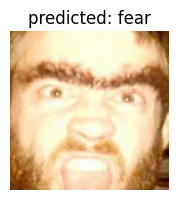

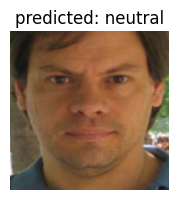

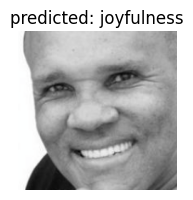

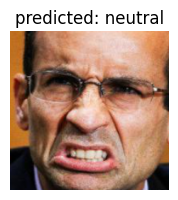

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

F1-Score macro:  0.53047200886452
F1-Score micro:  0.5786163522012578
F1-Score weighted:  0.5679113532839685
[25.         58.82352941 40.         76.92307692 63.04347826]


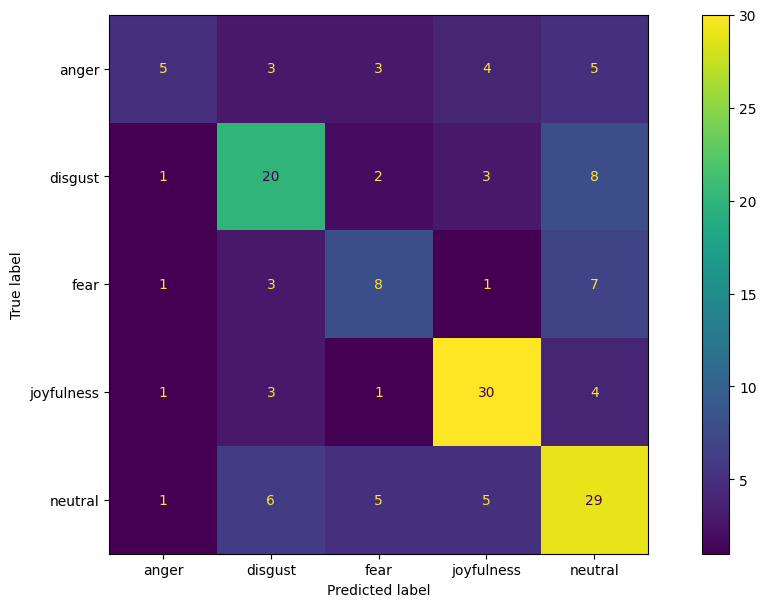

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
#print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
print('========================================================')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

Проход обучения предобученной модели без заморозки слоев EfficientNet B0 из библиотеки Timm

In [ ]:
# Посмортим какие имеются претренированные модели
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

# Тренировка предобученной модели efficientnet_b0.

Приведенный ниже график, взятый из [статьи](https://learnopencv.com/efficientnet-theory-code/), показывает кривую производительности семейства EfficientNet.


2023-03-15_10-57-16.png

Производительность EfficientNet по сравнению с другими архитектурами CNN. 
Это показывает, что при тех же сбоях точность EfficientNet выше, чем у любой существующей архитектуры. Итак, если вы планируете использовать Inception-v2, вам следует рассмотреть возможность использования EfficientNet-B1 вместо этого. Аналогичным образом, рекомендуется рассмотреть EfficientNet-B2, если вы планируете использовать ResNet-50.

В большинстве реальных приложений люди начинают с предварительно обученной модели и настраивают ее для своего конкретного применения.

Только потому, что EfficientNet превосходит другие сети, означает ли это, что он будет превосходить другие сети в других задачах?

Хорошей новостью является то, что авторы провели эти эксперименты и показали, что при использовании магистрали EfficientNet мы также получаем лучшую производительность в других задачах компьютерного зрения.


In [ ]:
efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
class My_Net_efficientnet_b0(torch.nn.Module):
    def __init__(self, model_name, pretrained=True, effnet=False, value=False):  
        super().__init__()
        self.model = efficientnet

        # Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
        for param in self.model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
           #param.requires_grad = True  Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать            
           #fc_inputs = self.model.classifier.in_features # Добавляем полносвязанную классифицирующую голову
           self.model.classifier = nn.Sequential(
           nn.Linear(1280, 256),
           nn.ReLU(),
           nn.Linear(256, 5))


    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model_efficientnet_b0 = My_Net_efficientnet_b0(model_name = 'efficientnet_b0', pretrained=True) # Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этой модели на датасете ImageNet
          
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b0 = model_efficientnet_b0.to(device)
 
# Определяем Loss функцию
# В данном случае - это кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamW
optimizer = torch.optim.AdamW(model_efficientnet_b0.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

In [ ]:
print(model_efficientnet_b0)

My_Net_efficientnet_b0(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

In [ ]:
summary(model=model_efficientnet_b0, 
        input_size=(8, 3, 256, 256), # входной батч
        col_names=["input_size", "output_size", "num_params"],
        col_width=20
)

Layer (type:depth-idx)                             Input Shape          Output Shape         Param #
My_Net_efficientnet_b0                             [8, 3, 256, 256]     [8, 5]               --
├─EfficientNet: 1-1                                [8, 3, 256, 256]     [8, 5]               --
│    └─Conv2d: 2-1                                 [8, 3, 256, 256]     [8, 32, 128, 128]    864
│    └─BatchNormAct2d: 2-2                         [8, 32, 128, 128]    [8, 32, 128, 128]    64
│    │    └─Identity: 3-1                          [8, 32, 128, 128]    [8, 32, 128, 128]    --
│    │    └─SiLU: 3-2                              [8, 32, 128, 128]    [8, 32, 128, 128]    --
│    └─Sequential: 2-3                             [8, 32, 128, 128]    [8, 320, 8, 8]       --
│    │    └─Sequential: 3-3                        [8, 32, 128, 128]    [8, 16, 128, 128]    1,448
│    │    └─Sequential: 3-4                        [8, 16, 128, 128]    [8, 24, 64, 64]      16,714
│    │    └─Sequential: 3-5

In [ ]:
model, loss_hist = train_model(model_efficientnet_b0, criterion, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:14<00:00,  9.20it/s]


train   |   Loss: 0.6480  |  Acc: 0.8315   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


validation   |   Loss: 0.4915  |  Acc: 0.8176   |   F1: 0.7143

Epoch 1/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.90it/s]


train   |   Loss: 0.2678  |  Acc: 0.9120   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.38it/s]


validation   |   Loss: 0.4840  |  Acc: 0.8176   |   F1: 1.0000

Epoch 2/29
----------


100%|██████████| 135/135 [00:12<00:00, 11.18it/s]


train   |   Loss: 0.2787  |  Acc: 0.9074   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 15.83it/s]


validation   |   Loss: 0.5130  |  Acc: 0.8176   |   F1: 0.7143

Epoch 3/29
----------


100%|██████████| 135/135 [00:18<00:00,  7.42it/s]


train   |   Loss: 0.2395  |  Acc: 0.9185   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.54it/s]


validation   |   Loss: 0.5134  |  Acc: 0.8239   |   F1: 1.0000

Epoch 4/29
----------


100%|██████████| 135/135 [00:15<00:00,  8.57it/s]


train   |   Loss: 0.2415  |  Acc: 0.9176   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


validation   |   Loss: 0.4952  |  Acc: 0.8491   |   F1: 0.8571

Epoch 5/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


train   |   Loss: 0.2123  |  Acc: 0.9296   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.89it/s]


validation   |   Loss: 0.4849  |  Acc: 0.8491   |   F1: 0.8571

Epoch 6/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.77it/s]


train   |   Loss: 0.2594  |  Acc: 0.9065   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.32it/s]


validation   |   Loss: 0.5022  |  Acc: 0.8302   |   F1: 0.8571

Epoch 7/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.83it/s]


train   |   Loss: 0.2447  |  Acc: 0.9111   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


validation   |   Loss: 0.5111  |  Acc: 0.8050   |   F1: 0.7143

Epoch 8/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.89it/s]


train   |   Loss: 0.2193  |  Acc: 0.9324   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.17it/s]


validation   |   Loss: 0.4917  |  Acc: 0.8491   |   F1: 0.8571

Epoch 9/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.75it/s]


train   |   Loss: 0.1873  |  Acc: 0.9389   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


validation   |   Loss: 0.4728  |  Acc: 0.8365   |   F1: 0.8571

Epoch 10/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.76it/s]


train   |   Loss: 0.1587  |  Acc: 0.9426   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


validation   |   Loss: 0.4621  |  Acc: 0.8616   |   F1: 0.7143

Epoch 11/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.79it/s]


train   |   Loss: 0.1271  |  Acc: 0.9620   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


validation   |   Loss: 0.5655  |  Acc: 0.8176   |   F1: 0.8571

Epoch 12/29
----------


100%|██████████| 135/135 [00:13<00:00,  9.93it/s]


train   |   Loss: 0.1417  |  Acc: 0.9519   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


validation   |   Loss: 0.4897  |  Acc: 0.8553   |   F1: 0.7143

Epoch 13/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.88it/s]


train   |   Loss: 0.1199  |  Acc: 0.9574   |   F1: 0.7500


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


validation   |   Loss: 0.6214  |  Acc: 0.8239   |   F1: 1.0000

Epoch 14/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.93it/s]


train   |   Loss: 0.1404  |  Acc: 0.9509   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.46it/s]


validation   |   Loss: 0.6211  |  Acc: 0.8113   |   F1: 0.8571

Epoch 15/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.76it/s]


train   |   Loss: 0.1483  |  Acc: 0.9500   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.25it/s]


validation   |   Loss: 0.5460  |  Acc: 0.7987   |   F1: 0.7143

Epoch 16/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.85it/s]


train   |   Loss: 0.1367  |  Acc: 0.9454   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


validation   |   Loss: 0.5789  |  Acc: 0.8302   |   F1: 0.8571

Epoch 17/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.81it/s]


train   |   Loss: 0.1748  |  Acc: 0.9426   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.14it/s]


validation   |   Loss: 0.5680  |  Acc: 0.8176   |   F1: 0.8571

Epoch 18/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.81it/s]


train   |   Loss: 0.2320  |  Acc: 0.9250   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.29it/s]


validation   |   Loss: 0.5900  |  Acc: 0.8365   |   F1: 0.7143

Epoch 19/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.80it/s]


train   |   Loss: 0.2233  |  Acc: 0.9296   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.77it/s]


validation   |   Loss: 0.5804  |  Acc: 0.8176   |   F1: 0.7143

Epoch 20/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.72it/s]


train   |   Loss: 0.1660  |  Acc: 0.9407   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


validation   |   Loss: 0.5445  |  Acc: 0.8491   |   F1: 0.7143

Epoch 21/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.86it/s]


train   |   Loss: 0.0835  |  Acc: 0.9750   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.56it/s]


validation   |   Loss: 0.5785  |  Acc: 0.8239   |   F1: 0.8571

Epoch 22/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.69it/s]


train   |   Loss: 0.0757  |  Acc: 0.9750   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.52it/s]


validation   |   Loss: 0.7023  |  Acc: 0.8050   |   F1: 0.5714

Epoch 23/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.84it/s]


train   |   Loss: 0.0976  |  Acc: 0.9694   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.98it/s]


validation   |   Loss: 0.6768  |  Acc: 0.8176   |   F1: 1.0000

Epoch 24/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.84it/s]


train   |   Loss: 0.0943  |  Acc: 0.9704   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.37it/s]


validation   |   Loss: 0.6565  |  Acc: 0.8176   |   F1: 1.0000

Epoch 25/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.86it/s]


train   |   Loss: 0.0865  |  Acc: 0.9759   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


validation   |   Loss: 0.6421  |  Acc: 0.8302   |   F1: 0.7143

Epoch 26/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.83it/s]


train   |   Loss: 0.1173  |  Acc: 0.9583   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


validation   |   Loss: 0.7106  |  Acc: 0.7987   |   F1: 1.0000

Epoch 27/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.75it/s]


train   |   Loss: 0.1149  |  Acc: 0.9611   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


validation   |   Loss: 0.7348  |  Acc: 0.8428   |   F1: 1.0000

Epoch 28/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


train   |   Loss: 0.1677  |  Acc: 0.9417   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.67it/s]


validation   |   Loss: 0.7341  |  Acc: 0.8302   |   F1: 0.7143

Epoch 29/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.85it/s]


train   |   Loss: 0.2279  |  Acc: 0.9259   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


validation   |   Loss: 0.6981  |  Acc: 0.8428   |   F1: 0.8571

Training complete in 6m 57s
Best val Acc: 0.861635


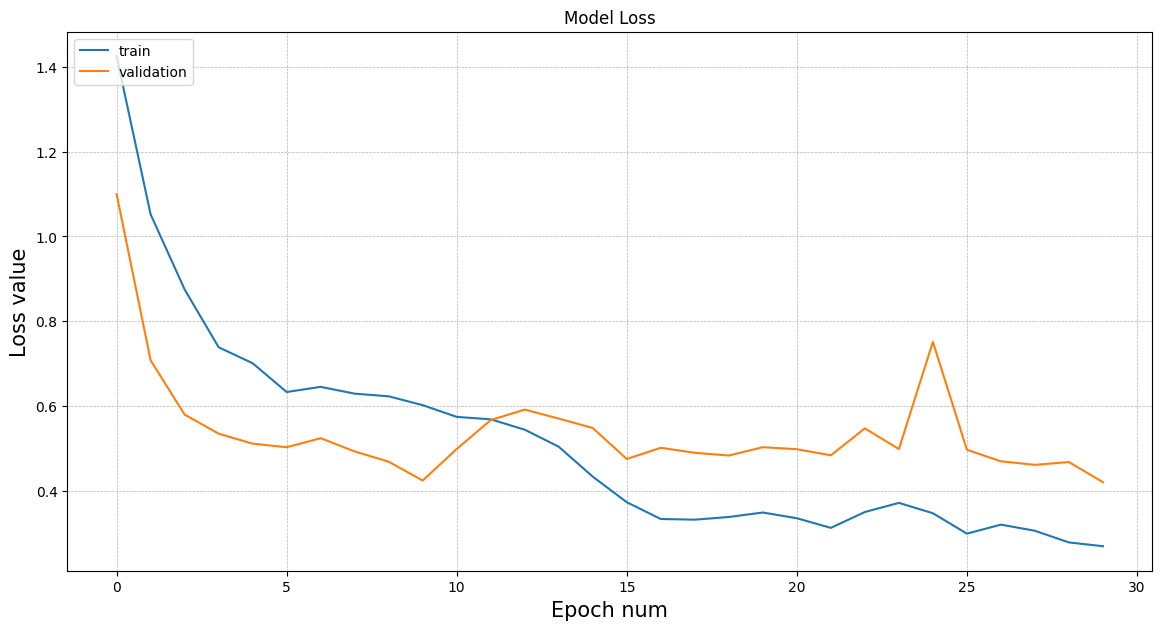

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

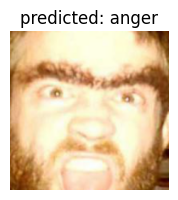

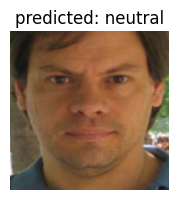

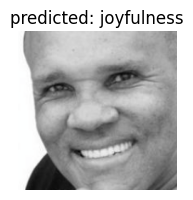

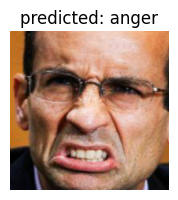

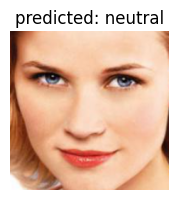

In [ ]:
visualize_model(model)

plt.ioff()
plt.show()

In [ ]:
nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

F1-Score macro:  0.8325039470806062
F1-Score micro:  0.8490566037735849
F1-Score weighted:  0.8479311482895093
[65.         82.35294118 85.         92.30769231 89.13043478]


Пример работы высокоуровневой надстройки над PyTorch - Ignite

In [43]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 3.5 MB/s eta 0:00:00


In [44]:
!pip install --pre pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
model_ignite = timm.create_model('efficientnet_b0', pretrained=True)

model_ignite.classifier = nn.Sequential(
           nn.Linear(1280, 256),
           nn.ReLU(),
           nn.Linear(256, len(class_names)))

model_ignite = model_ignite.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model_ignite.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

In [84]:
from ignite.engine import Engine, _prepare_batch
scaler = torch.cuda.amp.GradScaler()

def process_function(engine, batch):
    model_ignite.train()
    torch.set_grad_enabled(True)
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model_ignite(x)
    loss = criterion(y_pred, y)
    #loss.backward()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()
    return loss.item()

trainer = Engine(process_function)

In [79]:
from ignite.engine import Events

log_interval = len(image_datasets['train'])

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(image_datasets['train']) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(image_datasets['train']), 
                         engine.state.output))

In [48]:
from ignite.engine import Engine
from ignite.metrics import Accuracy, Precision, Recall, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar

In [49]:
metrics = {
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True),
    'Loss': Loss(criterion)
    
}

In [85]:
from ignite.engine import create_supervised_evaluator

# Напомним, что device = “cuda” был определен выше
train_evaluator = create_supervised_evaluator(model_ignite, metrics=metrics, device=device)
pbar = ProgressBar()
pbar.attach(trainer)
val_evaluator = create_supervised_evaluator(model_ignite, metrics=metrics, device=device)
training_history = {'avg_accuracy':[],'Loss':[]}
validation_history = {'avg_accuracy':[],'Loss':[]}
last_epoch = []

In [51]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'Loss')

In [86]:
import numpy as np
from torch.utils.data.dataset import Subset

indices = np.arange(len(image_datasets['train']))
random_indices = np.random.permutation(indices)[:len(image_datasets['validation'])]
train_subset = Subset(image_datasets['train'], indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=CFG.batch_size, shuffle=True,
                                num_workers=CFG.num_workers, 
                                drop_last=True, pin_memory=device)

In [87]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_eval_loader).metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['Loss']
    last_epoch.append(0)
    training_history['avg_accuracy'].append(accuracy)
    training_history['Loss'].append(loss)
    print("Training Results - Epoch: {}  Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | Loss: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      metrics['Loss']
                      ))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(train_eval_loader).metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['Loss']
    last_epoch.append(0)
    training_history['avg_accuracy'].append(accuracy)
    training_history['Loss'].append(loss)
    print("Validation Results - Epoch: {}  Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | Loss: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      metrics['Loss']
                      ))

In [88]:
from ignite.handlers import Timer, BasicTimeProfiler
basic_profiler = BasicTimeProfiler()
basic_profiler.attach(trainer)
trainer = trainer.run(train_eval_loader, max_epochs=30)

[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 1  Accuracy: 0.6053 | Precision: 0.6955 | Recall: 0.5639 | Loss: 1.2035
Compute validation metrics...
Validation Results - Epoch: 1  Accuracy: 0.5658 | Precision: 0.4460 | Recall: 0.5242 | Loss: 1.2307


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 2  Accuracy: 0.6184 | Precision: 0.6860 | Recall: 0.5684 | Loss: 1.0492
Compute validation metrics...
Validation Results - Epoch: 2  Accuracy: 0.5789 | Precision: 0.4654 | Recall: 0.5277 | Loss: 1.0955


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 3  Accuracy: 0.6513 | Precision: 0.5187 | Recall: 0.6199 | Loss: 0.9968
Compute validation metrics...
Validation Results - Epoch: 3  Accuracy: 0.6711 | Precision: 0.5349 | Recall: 0.6213 | Loss: 0.9708


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 4  Accuracy: 0.7039 | Precision: 0.6738 | Recall: 0.6596 | Loss: 0.8516
Compute validation metrics...
Validation Results - Epoch: 4  Accuracy: 0.6974 | Precision: 0.7537 | Recall: 0.6466 | Loss: 0.8035


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 5  Accuracy: 0.7237 | Precision: 0.7864 | Recall: 0.6731 | Loss: 0.7545
Compute validation metrics...
Validation Results - Epoch: 5  Accuracy: 0.7303 | Precision: 0.7865 | Recall: 0.6914 | Loss: 0.7499


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 6  Accuracy: 0.7171 | Precision: 0.6757 | Recall: 0.6771 | Loss: 0.6956
Compute validation metrics...
Validation Results - Epoch: 6  Accuracy: 0.7632 | Precision: 0.8096 | Recall: 0.7268 | Loss: 0.6504


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 7  Accuracy: 0.7763 | Precision: 0.7869 | Recall: 0.7397 | Loss: 0.6096
Compute validation metrics...
Validation Results - Epoch: 7  Accuracy: 0.8026 | Precision: 0.8306 | Recall: 0.7689 | Loss: 0.5537


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 8  Accuracy: 0.8421 | Precision: 0.8639 | Recall: 0.8004 | Loss: 0.4938
Compute validation metrics...
Validation Results - Epoch: 8  Accuracy: 0.8289 | Precision: 0.8607 | Recall: 0.7903 | Loss: 0.5355


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 9  Accuracy: 0.8684 | Precision: 0.8883 | Recall: 0.8374 | Loss: 0.4539
Compute validation metrics...
Validation Results - Epoch: 9  Accuracy: 0.8750 | Precision: 0.8924 | Recall: 0.8474 | Loss: 0.3914


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 10  Accuracy: 0.8750 | Precision: 0.8891 | Recall: 0.8653 | Loss: 0.4241
Compute validation metrics...
Validation Results - Epoch: 10  Accuracy: 0.8684 | Precision: 0.8593 | Recall: 0.8470 | Loss: 0.4402


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 11  Accuracy: 0.9211 | Precision: 0.9274 | Recall: 0.9151 | Loss: 0.3733
Compute validation metrics...
Validation Results - Epoch: 11  Accuracy: 0.8947 | Precision: 0.8880 | Recall: 0.8754 | Loss: 0.3917


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 12  Accuracy: 0.8882 | Precision: 0.8780 | Recall: 0.8797 | Loss: 0.3377
Compute validation metrics...
Validation Results - Epoch: 12  Accuracy: 0.8947 | Precision: 0.9042 | Recall: 0.9002 | Loss: 0.3811


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 13  Accuracy: 0.9276 | Precision: 0.9214 | Recall: 0.9239 | Loss: 0.2980
Compute validation metrics...
Validation Results - Epoch: 13  Accuracy: 0.9145 | Precision: 0.9227 | Recall: 0.8898 | Loss: 0.3068


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 14  Accuracy: 0.9211 | Precision: 0.9136 | Recall: 0.9271 | Loss: 0.3209
Compute validation metrics...
Validation Results - Epoch: 14  Accuracy: 0.9342 | Precision: 0.9264 | Recall: 0.9378 | Loss: 0.2694


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 15  Accuracy: 0.8750 | Precision: 0.8732 | Recall: 0.8718 | Loss: 0.3028
Compute validation metrics...
Validation Results - Epoch: 15  Accuracy: 0.9276 | Precision: 0.9144 | Recall: 0.9224 | Loss: 0.2611


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 16  Accuracy: 0.8947 | Precision: 0.8968 | Recall: 0.9044 | Loss: 0.2749
Compute validation metrics...
Validation Results - Epoch: 16  Accuracy: 0.8947 | Precision: 0.8899 | Recall: 0.8889 | Loss: 0.2651


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 17  Accuracy: 0.9539 | Precision: 0.9532 | Recall: 0.9458 | Loss: 0.1898
Compute validation metrics...
Validation Results - Epoch: 17  Accuracy: 0.9408 | Precision: 0.9307 | Recall: 0.9305 | Loss: 0.2082


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 18  Accuracy: 0.9539 | Precision: 0.9644 | Recall: 0.9557 | Loss: 0.2085
Compute validation metrics...
Validation Results - Epoch: 18  Accuracy: 0.8816 | Precision: 0.8861 | Recall: 0.8741 | Loss: 0.2710


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 19  Accuracy: 0.9145 | Precision: 0.9216 | Recall: 0.9053 | Loss: 0.2424
Compute validation metrics...
Validation Results - Epoch: 19  Accuracy: 0.9539 | Precision: 0.9463 | Recall: 0.9530 | Loss: 0.1826


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 20  Accuracy: 0.9408 | Precision: 0.9536 | Recall: 0.9307 | Loss: 0.1637
Compute validation metrics...
Validation Results - Epoch: 20  Accuracy: 0.9539 | Precision: 0.9541 | Recall: 0.9579 | Loss: 0.1541


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 21  Accuracy: 0.9474 | Precision: 0.9426 | Recall: 0.9314 | Loss: 0.1794
Compute validation metrics...
Validation Results - Epoch: 21  Accuracy: 0.9539 | Precision: 0.9646 | Recall: 0.9491 | Loss: 0.1597


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 22  Accuracy: 0.9605 | Precision: 0.9699 | Recall: 0.9551 | Loss: 0.1384
Compute validation metrics...
Validation Results - Epoch: 22  Accuracy: 0.9342 | Precision: 0.9263 | Recall: 0.9227 | Loss: 0.2144


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 23  Accuracy: 0.9474 | Precision: 0.9430 | Recall: 0.9473 | Loss: 0.1665
Compute validation metrics...
Validation Results - Epoch: 23  Accuracy: 0.9539 | Precision: 0.9562 | Recall: 0.9485 | Loss: 0.1821


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 24  Accuracy: 0.9737 | Precision: 0.9692 | Recall: 0.9782 | Loss: 0.1279
Compute validation metrics...
Validation Results - Epoch: 24  Accuracy: 0.9342 | Precision: 0.9284 | Recall: 0.9382 | Loss: 0.2050


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 25  Accuracy: 0.9539 | Precision: 0.9527 | Recall: 0.9575 | Loss: 0.1515
Compute validation metrics...
Validation Results - Epoch: 25  Accuracy: 0.9737 | Precision: 0.9776 | Recall: 0.9775 | Loss: 0.1553


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 26  Accuracy: 0.9474 | Precision: 0.9434 | Recall: 0.9355 | Loss: 0.1718
Compute validation metrics...
Validation Results - Epoch: 26  Accuracy: 0.9408 | Precision: 0.9469 | Recall: 0.9318 | Loss: 0.1981


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 27  Accuracy: 0.9671 | Precision: 0.9726 | Recall: 0.9691 | Loss: 0.1545
Compute validation metrics...
Validation Results - Epoch: 27  Accuracy: 0.9605 | Precision: 0.9601 | Recall: 0.9601 | Loss: 0.1417


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 28  Accuracy: 0.9474 | Precision: 0.9455 | Recall: 0.9417 | Loss: 0.1458
Compute validation metrics...
Validation Results - Epoch: 28  Accuracy: 0.9605 | Precision: 0.9640 | Recall: 0.9551 | Loss: 0.1341


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 29  Accuracy: 0.9605 | Precision: 0.9511 | Recall: 0.9577 | Loss: 0.1414
Compute validation metrics...
Validation Results - Epoch: 29  Accuracy: 0.9342 | Precision: 0.9332 | Recall: 0.9418 | Loss: 0.1768


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 30  Accuracy: 0.9605 | Precision: 0.9539 | Recall: 0.9629 | Loss: 0.1166
Compute validation metrics...
Validation Results - Epoch: 30  Accuracy: 0.9671 | Precision: 0.9661 | Recall: 0.9645 | Loss: 0.1422


F1-Score macro:  0.6313461902847293
F1-Score micro:  0.6792452830188679
F1-Score weighted:  0.6887096162403267
[40.         76.47058824 40.         89.74358974 67.39130435]


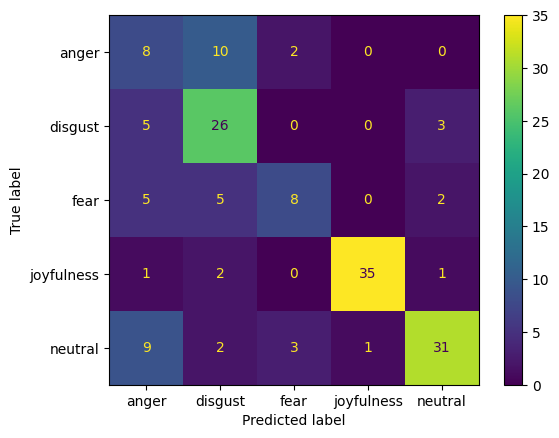

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ignite(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

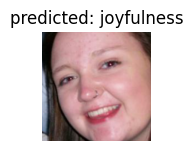

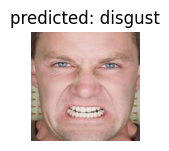

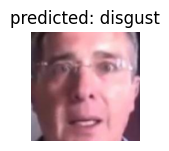

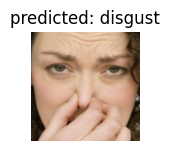

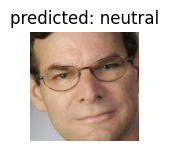

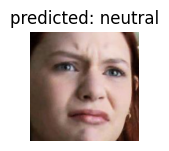

In [90]:
visualize_model(model_ignite)

plt.ioff()
plt.show()

Ссылки на источники.

https://questu.ru/articles/155907/ - Внедрение EfficientNet в PyTorch, часть 2: решение/

https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/ - Передача обучения с использованием EfficientNet PyTorch/

https://duchesnay.github.io/pystatsml/deep_learning/dl_cnn_cifar10_pytorch.html - Convolutional neural network/

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR - документация STEPLR.

https://pytorch.org/vision/master/_modules/torchvision/models/efficientnet.html - SOURCE CODE FOR TORCHVISION.MODELS.EFFICIENTNET.

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier - ОБУЧЕНИЕ КЛАССИФИКАТОРА.

https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50 - RESNET50 документация модели.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html - ПЕРЕДАЧА ОБУЧЕНИЯ ДЛЯ КОМПЬЮТЕРНОГО ЗРЕНИЯ УЧЕБНОЕ ПОСОБИЕ.

https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html#torcheval.metrics.functional.multiclass_f1_score - multiclass_f1_score документация.


https://timm.fast.ai/training - Как обучать свои собственные модели с помощью timm.

https://habr.com/ru/company/intel/blog/420635/ - AI, практический курс. Базовая модель распознавания эмоций на изображениях.

https://habr.com/ru/post/456186/ - CS231n: Свёрточные нейронные сети для распознавания образов.

https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752 - Правильная настройка случайного начального значения в экспериментах ML.

https://medium.com/@nutanbhogendrasharma/image-classification-with-pytorch-351a0a6cc09d - Классификация изображений с помощью PyTorch.

https://www.kaggle.com/code/veb101/facial-expression-recognition-using-pytorch - Facial Expression Recognition using Pytorch.

https://digitrain.ru/articles/369516/ - Классификация изображений с использованием логистической регрессии в PyTorch.

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab - PyTorch  — многоклассовая классификация.

https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch - Измерение оценки F1 для многоклассовой классификации в PyTorch.

https://stackoverflow.com/questions/67959327/how-to-calculate-the-f1-score - Как рассчитать оценку f1.

https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial - Матрица и точность тестирования для учебного пособия по передаче обучения PyTorch.

https://github.com/pytorch/torcheval - TorchEval документация.

https://wandb.ai/wandb_fc/tips/reports/How-To-Use-GradScaler-in-PyTorch--VmlldzoyMTY5MDA5 - Как использовать GradScaler в PyTorch/


# 1.3. Подготовка функций и переменных для обучения | <b>TensorFlow</b>

## Архитектура, компиляция, обучение модели

`DROPOUT_RATE` назначим небольшим, так как датасет у нас скромный по объему и, если мы будем исключать значительную часть датасета из обучения, модель просто не сможет обучаться.

Также назначим переменную базовый learning rate - `BASE_LR`, установим значение на 0.01. Мы будем использовать специальный инструмент `callbacks`, который при необходимости будет уменьшать данный параметр непосредственно в ходе обучения.

In [ ]:
DROPOUT_RATE = 0.2
BASE_LR = 0.01
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)
EPOCHS=500  # см. callbacks

В качестве метрик будем использовать традиционную `accuracy` (в дань уважения традиции, для оценки работы классификатора на несбаланированных данных эта метрика не имеет большого смысла, так как она считает среднее по ошибкам, не учитывая крайности) и `PR-AUC` - площадь под графиком метрик precision и recall, которая позволяет учесть данные по редким классам и получить более объективную картину об эффективности обучения в нашем случае. Также можно было использовать метрику F1 Score, но готовый класс этой метрики на данный момент доступна только в "ночной" версии tf, а прописывать свой собственный класс мы не стали в связи с наличием готового инструмента PR-AUC, вполе удовлетворяющего нашим задачам.

In [ ]:
curve = 'PR'
name = curve+'_AUC'
AUC = tf.keras.metrics.AUC(curve=curve, multi_label=False, name=name)

# список с метриками
metrics = ['accuracy', AUC]

### Callbacks - контроль остановки обучения и `learning_rate`

Так как обучение моделей по компьютерному зрению очень затратно по ресурсам, а мы проводили целый ряд различных экспериментов, для снижения нагрузки на систему мы использовали так называемые `callbacks` - специальные модули `keras`, которые позволяют в автомтическом режиме контролировать, когда следует вносить те или иные изменения в обучение и даже останавливать его. Мы будем использовать два вида `callbacks`:

- `EarlyStopping` для ранней остановки обучения при прекращении уменьшения `val_loss` (для нашего несбалансированного датасета этот показатель важнее, чем непоказательный для несбалансированных классов `val_accuracy`),

- `ReduceLROnPlateau` для уменьшения `learning rate` при ухудшении показателей `val_loss` (постепенное снижение `learning rate` в процессе обучения положительно сказывается на качестве обучения, что мы увидели на наших экспериментах).

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # минимальное значение для зачета улучшения
    patience=12,  # количество эпох с плохим результатом перед остановкой
    restore_best_weights=True,  # восстановить лучшие показатели модели
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=0.85,  # на какое значение будет умножаться текущий lr
    min_lr=1e-8  # минимальное значение lr
)

Таким образом, наши callbacks создают следующий алгоритм: 
- при ухудшении `val_loss` на данной эпохе следующая эпоха будет прходить с `learning rate` на 15% ниже,
- если `val_loss` не улучшается 12 раз кряду, обучение прекращается.

Все эти параметры можно регулировать и подбирать, для наших задач мы остановимся на этих гиперпараметрах, так как в ходе экспериментов они показали себя достаточно эффективными.

## Визуализация итогов обучения

Также пропишем функции для отрисовки результатов обучения - графики функции потерь и метрик (обучающая и валидационная выборка), а также матрицу ошибок (тестовая выборка).

### Функция потерь и метрики

In [ ]:
def val_acc_viz(history, epochs, loss_from=1):
    '''
    Функция отрисовывает историю функции потерь и
    используемых метрик. Аргументы:
    - history - данные истории обучения,
    - epochs - количество эпох для отображения,
    - loss_from - с какой эпохи отображать loss.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    auc = history.history[name]
    val_auc = history.history['val_' + name]

    loss = history.history['loss'][loss_from-1:]
    val_loss = history.history['val_loss'][loss_from-1:]

    epochs_range = range(1, len(acc)+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(loss_from, len(acc)+1), loss, label='Training Loss')
    plt.plot(range(loss_from, len(acc)+1), val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    # plt.show()

    # plt.figure(figsize=(8, 5))
    # ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    # plt.subplot(1, 2, 2, sharey=ax1)
    plt.subplot(1, 3, 3, sharey=ax2)
    plt.plot(epochs_range, auc, label='Training ' + name)
    plt.plot(epochs_range, val_auc, label='Validation ' + name)
    plt.legend(loc='best')
    plt.title(name)
    plt.xlabel('epochs')
    plt.show()

### Функция матрицы ошибок

В функции матрицы ошибок использованы инструменты библиотеки scikit-learn, что особенно удобно для отрисовки матрицы, хотя при желании можно прописать функцию отрисовки матрицы вручную.

In [ ]:
def confusion_matrix(model, dataset, images_number=None, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - dataset - tf.dataset с тестовыми изображениями.
    - images_number - int: количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке (по
            условию).
    - class_names - list: названия классов.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)

    y_test = list()
    y_pred = list()
    for x, y in test_batches:
        y_test.append(np.argmax(y))
        y_pred.append(np.argmax(model.predict(x, verbose=0)))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='GnBu')
    # disp.plot(cmap='afmhot')

    plt.show()

## Предсказания на изображениях из тестовой выборки

Следующая функция покажет предсказания по заданному числу изображений из тестовой выборки (по условию 10), реальное и предсказанное значение класса, изображение при активации `visualization`), а также "уверенность" модели в своем предсказании. 

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, dataset,
                     images_number=10, visualization=False):

    '''
    Функция предсказания по заданному числу изображений из тестовой
    выборки (по условию 10), реальное и предсказанное значение класса,
    изображение при активации `visualization`), а также
    "уверенность" модели в своем предсказании.
    
    Аргументы:
    -  model - обученная модель.
    - images_number - int: количество изображений, предсказания по которым
      мы хотим получить (по условию 10).
    - visualization - bool: отрисовка изображений (по условию False).
    
    '''
    
    images = dataset.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img, verbose=0)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

# <b>2. МОДЕЛИ</b>

# <b>2.1. PyTorch</b>

# <b>2.2. TensorFlow</b>

## <b>Предварительные замечания</b>

### О выбранной тактике обучения моделей

В данной работе представлены две модели, реализованные инструментами библиотеки TensorFlow. Обе модели обучены на предобученных моделях, которые используются для задачи классификации изображений - `InceptionV3` и `MobileNetV2` (обе обучены на базе данных ImageNet). Подробно о моделях можно прочитать в специальных статьях, ссылки на которые приведены ниже.

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:

- с использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации, однако у него есть существенный для разработчика недостаток - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (то есть мы имеем дело с семействами моделей). Также два способа отличаются методом `rescale` - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение.

Мы используем второй способ, так как он гораздо более пластичен для тонкой настройки и позволяет экспериментировать с гиперпараметрами.

Всего для подотовки дипломного проекта было использовано четыре различных предобученных модели с использованием различных оптимизаторов (`SGD`, `RMSprop`, `Adam`) и функций потерь (`mse`, `categorical crossentropy`), лучшие параметры были определены в ходе ряда экспериментов. С большей частью экспериментов можно ознакомиться по [ссылке](https://github.com/lefthand67/SBER_Diploma/tree/main/experiments) (подробных словесных описаний на данный момент нет, но названия и подписи говорят сами за себя).

В данной работе представлены модели, построенные на связке `RMSprop/mse`, как показавшие себя с лучшей стороны. Также эксперименты показали, что данный датасет с данной связкой optimizer/loss повышает эффективность обучения при добавлении в слой классификации регуляризатора Ridge Regression (`L2`) со степенью 0.5 (эксперименты проведены на созданной с нуля нейросети, без предобученной модели). Для снижения вероятности переобучения добавлены слои аугментации и слой `dropout` (степень 0.2). 

Архитектура представленных в работе моделей отличается минимализмом - отсутствуют слои свертки и дополнительные полносвязные слои перед классификатором, так как на экспериментах данные опыты дали результат хуже базовых моделей ([эксперименты](https://github.com/lefthand67/SBER_Diploma/blob/main/experiments/01_tf_pretrained_InceptionResNetV2.ipynb) проводились на предобученной модели `InceptionResNetV2`).

Обучение представленных моделей происходило в два этапа: 
- сначала обучается классификатор на базе предобученной модели, у которой отключены верхние слои (include_top=False),
- затем мы размораживаем часть слоев предобученной модели и дообучаем наш классификатор.

Рассмотрим эти этапы подробнее.

### `feature_extractor` и `bottleneck layer`

На первом этапе создается `feature_extractor`, который извлекает веса из предобученной модели для переноса обучения на нашу модель. При переносе обучения рекомендуется отключать самые "верхние", то есть последние слои, вплоть до самого последнего перед слоем `Flatten` предобученной модели: именно в них происходит обучение на данную классификацию, в то время как мы собираемся строить свой классификатор. Самый последний слой перед `Flatten` содержит самые  общие признаки изображений (в литературе его называют слоем "бутылочное горлышко" - "bottleneck layer"), именно поэтому он представляет для нас наибольшую ценность. Данная задача решается отключением аргмуента `include_top` и добавлением слоя `Flatten` для перевода тензора изображений в векторный вид (или можно просто активировать аргумент `pooling` внутри самого `feature_extractor`). 

### Разморозка слоев

За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения (в первых двух блоках он установлен в режим `False`). В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор c отключенным режимом `training`, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена. Кроме того, в общем случае нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений, тогда как цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете (тем не менее в модели с использованием MobileNetV2 мы разморозим все слои ввиду минималистичности данной предобученной модели, специально разработанной для переносных устройств).

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение, используемые для нормализации текущего батча. Запустив модель в режиме `training=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть (`feature_extractor.trainable=True`), слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

## <b>Подготовка данных для модели</b>

Подготовим все необходимые переменные для создания датасетов под данные модели. На данном этапе пропишем переменные для первой модели с использованием InceptionV3, чтобы проверить корректность работы всех инструментов. Для второй модели мы внесем изменения в свое время.

### Гиперпараметры для модели с переносом обучения

Пропишем гиперпараметры для модели, которые обеспечат нам правильную работу алгоритма.

In [ ]:
MODULE_HANDLE = 'tf.keras.applications.InceptionV3'

pixels = 299  # разрешение изображений, используемое в InceptionV3

IMAGE_SIZE = (pixels, pixels)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.InceptionV3, входное разрешение: (299, 299), размер батча: 32.


### Создание датасетов | `image_dataset_from_directory`

Для обучения модели предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. В качестве `label_mode` установим `categorical` для перевода лейблов в вид `one_hot_encoding`.

Весь необходимый код оформим в функцию, которая в одну строчку создаст три датасета под любую предобученную модель.

In [ ]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical',
                  seed=123):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [ ]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [ ]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 299, 299, 3)
(32, 299, 299, 3)
(1, 299, 299, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [ ]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)

class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Визуализация изображений из `train_batches`

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

C:\Users\Red_Plague\AppData\Local\Temp\ipykernel_7216\3032689920.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, i+1)


Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(299, 299, 3)


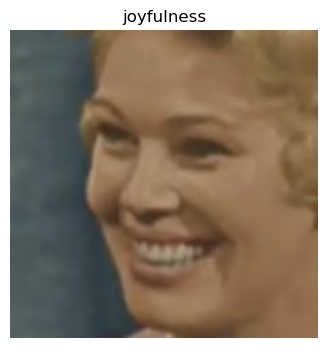

In [ ]:
# одно случайное изображение
for images, labels in train_batches.take(30):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

### Слои для препроцессинга изображений

#### Rescale

Стандартизация значений матриц изображений - обязательная операция, если мы хотим получить хорошие результаты по работе нашей сети. Для использования данной предобученной модели значения матриц изображений необходимо отшкалировать по стандарту от -1 до 1 (именно такой стандарт использовался для обучения этой сети). Есть два способа создания соответствующего слоя:

```python
# для модели InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

или

# для любой модели
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```

In [ ]:
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./127.5, offset=-1,
                                  input_shape=IMAGE_SIZE + (3,),
                                  name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -0.825291 0.43412113


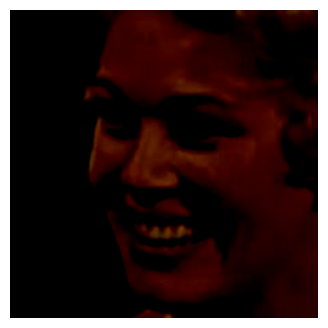

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(one_pic, axis=0))
# print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
# print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения. Это нормально, так как значения матрицы изображений были растянуты по обе стороны от 0. В любом случае, алгоритм обнаруживает зависимости не по внешнему виду картинок, как человеческий глаз, а исходя из числовых значений тензоров изображений.

#### Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast` (отключен). 

In [ ]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.3), name='RandomZoom'),
    # tf.keras.layers.RandomContrast(factor=(0.1, 0.1), name='RandomContrast')
])

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug).numpy()
# print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented));

print("Минимальное и максимальное значение пикселей:", augmented.min(), augmented.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -0.8142109 0.42450336


Итак, обе последовательности успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

### Оптимизация работы кэша

Перед началом работы оптимизируем работу кэша следующим кодом:

In [ ]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

## <b>Модель 2.2.1</b> | InceptionV3 

Authors: Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna

https://arxiv.org/abs/1512.00567

### Модуль `tf.keras.applications` | `feature_extractor_layer`

Создаем `feature_extractor` для обучения классификатора. 

In [ ]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionV3(
                                                include_top=False,
                                                weights="imagenet",
                                                input_shape=IMG_SHAPE
)
feature_extractor.trainable = do_fine_tuning

87924736/87910968 [==============================] - 21s 0us/step


### Архитектура модели

In [ ]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='InceptionV3_based')

model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 batch_normalization_96 (Bat  (None, 131072)     

Посморим на количество переменных, которые будут обучаться в данной архитектуре.

In [ ]:
len(model.trainable_variables)

4

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
 3/34 [=>............................] - ETA: 6:41 - loss: 101.6424 - accuracy: 0.3438 - PR_AUC: 0.2972

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

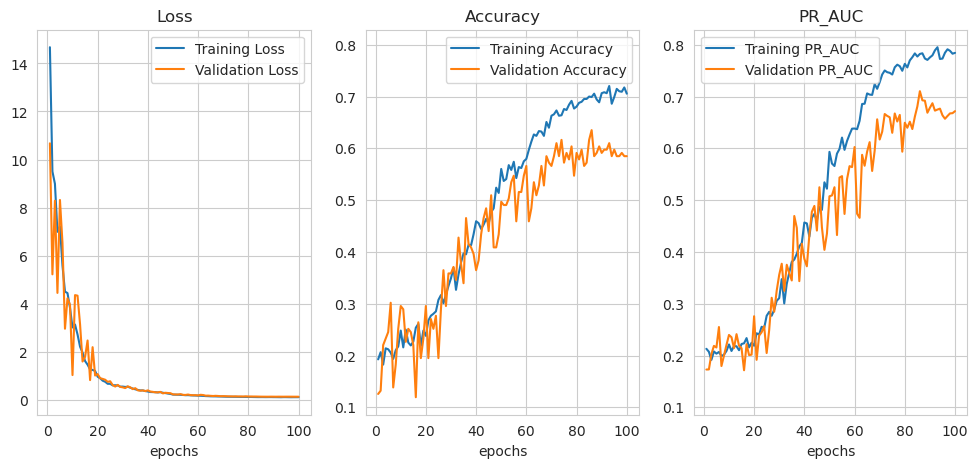

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, test_batches, visualization=False)

neutral is neutral (29.55%)
joyfulness is joyfulness (69.09%)
neutral is neutral (71.41%)
neutral is neutral (36.94%)
disgust is disgust (61.67%)
fear is fear (37.67%)
anger is joyfulness (44.50%)
neutral is neutral (67.27%)
neutral is neutral (64.24%)
disgust is disgust (34.55%)


### Матрица ошибок

In [ ]:
confusion_matrix(model, test_batches)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.64
val_PR_AUC: 0.71


In [ ]:
# сохраним данные о модели
model_221 = model
hist_221 = hist
model_221_best_results = model_best_results

## Разморозка слоев

Второй этап - дообучение нашего классификатора.

In [ ]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


In [ ]:
# с какого слоя мы размораживаем модель
fine_tune_at = int(len(feature_extractor.layers)/2)

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [ ]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  311
Trainable variables in the feature extractor:  92


При желании можно посмотреть на архитектуру `feature_extractor`.

In [ ]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы внесенные изменения были применены. Уменьшим базовый lr, чтобы избежать быстрого переобучения модели.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [ ]:
model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 batch_normalization_96 (Bat  (None, 131072)     

In [ ]:
len(model.trainable_variables)

96

### Обучение

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 30s 408ms/step - loss: 0.1896 - accuracy: 0.5991 - PR_AUC: 0.6382 - val_loss: 0.1856 - val_accuracy: 0.6226 - val_PR_AUC: 0.6698 - lr: 1.0000e-04
Epoch 2/500
34/34 [==============================] - 12s 356ms/step - loss: 0.1591 - accuracy: 0.6731 - PR_AUC: 0.7474 - val_loss: 0.1551 - val_accuracy: 0.6730 - val_PR_AUC: 0.7502 - lr: 1.0000e-04
Epoch 3/500
34/34 [==============================] - 13s 369ms/step - loss: 0.1421 - accuracy: 0.7019 - PR_AUC: 0.7951 - val_loss: 0.1333 - val_accuracy: 0.7233 - val_PR_AUC: 0.8261 - lr: 1.0000e-04
Epoch 4/500
34/34 [==============================] - 12s 350ms/step - loss: 0.1243 - accuracy: 0.7546 - PR_AUC: 0.8427 - val_loss: 0.1472 - val_accuracy: 0.6667 - val_PR_AUC: 0.7442 - lr: 1.0000e-04
Epoch 5/500
34/34 [==============================] - 12s 363ms/step - loss: 0.1101 - accuracy: 0.7944 - PR_AUC: 0.8672 - val_loss: 0.1385 - val_accuracy: 0.6352 - val_PR_AUC: 0.7428 - lr: 8.5000e-05
Epoch

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, test_batches, visualization=False)

disgust is disgust (98.86%)
anger is anger (53.65%)
disgust is disgust (96.51%)
joyfulness is joyfulness (98.98%)
joyfulness is joyfulness (97.66%)
neutral is neutral (99.74%)
neutral is neutral (99.26%)
fear is fear (99.94%)
neutral is neutral (42.97%)
fear is fear (98.58%)


### Матрица ошибок

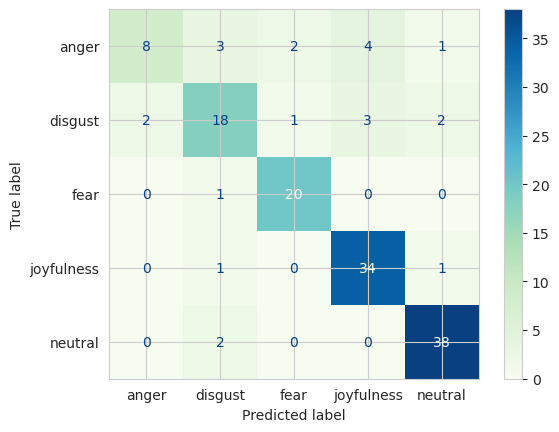

In [ ]:
confusion_matrix(model, test_batches)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.85
val_PR_AUC: 0.93


Итак, данная модель достигла минимальной цели в 80% и значительно ее превзошла.

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [ ]:
EMOTIONS_INCEPTIONV3_SAVED_MODEL = "./saved/inceptionv3_saved_model"

In [ ]:
tf.saved_model.save(model, EMOTIONS_INCEPTIONV3_SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


Сохраним также названия классов.

In [ ]:
Path.mkdir(Path('./saved/'))

with open('./saved/labels.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(class_names))

## <b>Модель 2.2.2</b> | MobileNetV2

Authors: Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen

https://arxiv.org/abs/1801.04381

### Новый `tf.dataset`

Для следующей модели нам потребуется заново создать `tf.dataset` под то разрешение изображений, которое используется в MobileNetV2 - (224, 224). 

In [ ]:
train_batches, validation_batches, test_batches = datasets_prep(image_size=(224, 224))

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


### Модуль `tf.keras.applications` | `feature_extractor_layer`

Теперь повторим все шаги, которые мы проделывали для предыдущей модели.

In [ ]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

9420800/9406464 [==============================] - 2s 0us/step


### Архитектура модели

In [ ]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='MobileNetV2_RMSprop_mse')

model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_4 (Dropout)         (None, 128000)            0         
                                           

In [ ]:
len(model.trainable_variables)

4

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
 3/34 [=>............................] - ETA: 2:08 - loss: 96.6646 - accuracy: 0.2188 - PR_AUC: 0.2617 

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, test_batches, visualization=True)

neutral is neutral (71.02%)
joyfulness is joyfulness (56.45%)
neutral is neutral (48.14%)
neutral is neutral (36.36%)
disgust is disgust (34.92%)
fear is neutral (40.47%)
anger is disgust (45.03%)
neutral is neutral (75.92%)
neutral is neutral (37.44%)
disgust is neutral (50.90%)


### Матрица ошибок

In [ ]:
confusion_matrix(model, test_batches)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.65
val_PR_AUC: 0.67


In [ ]:
# сохраним данные о модели
model_222 = model
hist_222 = hist
model_222_best_results = model_best_results

## Разморозка слоев

In [ ]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


На этот раз разморозим все слои.

In [ ]:
# с какого слоя мы размораживаем модель
fine_tune_at = 0

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [ ]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable variables in the feature extractor:  156


При желании можно посмотреть на архитектуру `feature_extractor`.

In [ ]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены. Уменьшим базовый lr, чтобы избежать переобучения нашй уже обученной модели.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [ ]:
model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_4 (Dropout)         (None, 128000)            0         
                                           

In [ ]:
len(model.trainable_variables)

160

### Обучение

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
 3/34 [=>............................] - ETA: 7:19 - loss: 2.0059 - accuracy: 0.2812 - PR_AUC: 0.2595

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

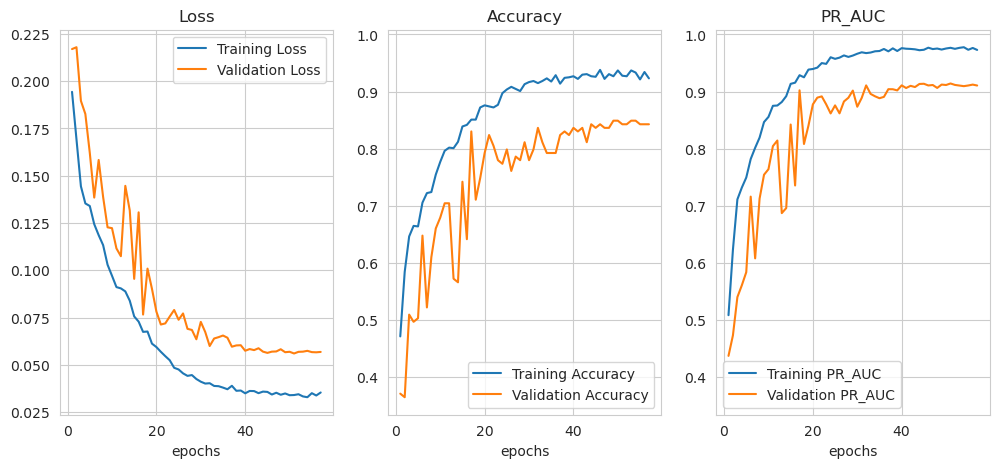

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, test_batches, visualization=True)

disgust is disgust (88.91%)
anger is disgust (93.53%)
disgust is fear (84.93%)
joyfulness is joyfulness (98.22%)
joyfulness is joyfulness (98.74%)
neutral is neutral (98.12%)
neutral is neutral (76.03%)
fear is fear (92.72%)
neutral is neutral (99.03%)
fear is fear (85.73%)


### Матрица ошибок

In [ ]:
confusion_matrix(model, test_batches)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.85
val_PR_AUC: 0.91


Данная модель также превзошла цель в 80%.

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [ ]:
EMOTIONS_MOBILENETV2_SAVED_MODEL = "./saved/momobilenetv2_saved_model"

In [ ]:
tf.saved_model.save(model, EMOTIONS_MOBILENETV2_SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


# <b>2.3. Scikit-learn</b>

# <b>Использованные источники и литература</b>

**Курсы**

1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow
1. Tensorflow Guide. TensorFlow Basics // https://www.tensorflow.org/guide

**Статьи**
1. Data augmentation // https://www.tensorflow.org/tutorials/images/data_augmentation
1. Image classification // https://www.tensorflow.org/tutorials/images/classification
1. Lakhani N.D. Statistical Evaluation Metrics // https://iust-projects.ir/post/minidm01/
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Preprocessing layers // https://keras.io/api/layers/preprocessing_layers/
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/
1. Working with preprocessing layers // https://www.tensorflow.org/guide/keras/preprocessing_layers

**Модели**
1. InceptionV3 // https://keras.io/api/applications/inceptionv3/
1. MobileNet // https://keras.io/api/applications/mobilenet/

**Форумы**
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/